In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [2]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0
)
response=llm.invoke("what is length of wall of china?")

response.content

"<think>\nOkay, so I need to figure out the length of the Great Wall of China. I remember hearing that it's really long, but I'm not exactly sure how long. I think it's somewhere in the thousands of miles, but I'm not certain. Let me try to break this down.\n\nFirst, I know the Great Wall is a series of fortifications built across several Chinese dynasties. It wasn't built all at once, so maybe that's why the length can vary. I've heard different numbers before, like 13,000 miles or 21,000 kilometers. But I'm not sure which one is accurate.\n\nI should consider the sources of this information. Maybe some people measure it differently. For example, if you include all the branches and sections, it might add up to a longer distance. But if you just take the main wall, it might be shorter. I think the Chinese government did a survey a while back, so that might be a reliable source.\n\nWait, I think they used advanced technology like GPS and satellites to measure it more accurately. That wo

In [3]:
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """
    Divide two integers.

    Args:
        a (int): The numerator.
        b (int): The denominator (must not be 0).

    Returns:
        float: The result of division.
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero.")
    return a / b

In [4]:
# importing in-built tool
from langchain_community.tools import DuckDuckGoSearchRun

In [5]:
search=DuckDuckGoSearchRun()
search.invoke("what is the latest update on iphone 17")

'iPhone 17: New slimmer \'iPhone 17 Air\' model. ... Various rumors suggest that the new iPhones could benefit from the following updates: Design and display. 2025 could bring one of the biggest updates to the iPhone\'s design that we\'ve seen since the 2017 iPhone X, with Apple rumored to be planning for an all-new iPhone 17 "Air" that has a much thinner ... Apple has released the latest versions of its iPhone and iPad software: iOS 17.6 and iPadOS 17.6 are now available for download on your device. Here\'s what\'s new in these latest OS updates. Apple\'s iOS 17.7 upgrade was released alongside iOS 18, including many of the same security fixes.The iOS 17.7 update is for iPhone users who want to wait before upgrading to the latest Apple ... iOS 17.6 Features. Apple\'s milestone updates (iOS x.x) typically bring new features, enhancements, security patches, and bug fixes to iPhone users, but iOS 17.6\'s feature set is on the lighter ...'

In [6]:
tools = [multiply, add, divide, search]

In [7]:
# binding tools with LLM
llm_with_tools=llm.bind_tools(tools)

In [8]:
response= llm_with_tools.invoke("hi")

In [9]:
response.content

'Hello! How can I assist you today?'

In [10]:
response.tool_calls

[]

In [11]:
response= llm_with_tools.invoke("what is 2 + 2")

In [12]:
response.content

''

In [13]:
response.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'jad9hbmtj',
  'type': 'tool_call'}]

In [14]:
response= llm_with_tools.invoke("what is 10/2")
response.content

''

In [15]:
response.tool_calls

[{'name': 'divide',
  'args': {'a': 10, 'b': 2},
  'id': 'm5253348s',
  'type': 'tool_call'}]

In [16]:
response= llm_with_tools.invoke("what is the current age of the TATA Group")
response.content

''

In [17]:
response.tool_calls

[{'name': 'duckduckgo_search',
  'args': {'query': 'TATA Group age'},
  'id': 'gcbpm7qz5',
  'type': 'tool_call'}]

In [18]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState, StateGraph, END, START

In [19]:
builder=StateGraph(MessagesState)

In [20]:
SYSTEM_PROMPT="You are a helpful assistant tasked with using and performing arithmetic operation on a set of inputs."

In [21]:
def function_1(state:MessagesState):
    user_question = state['messages']
    input_question = [SYSTEM_PROMPT] + user_question

    response = llm_with_tools.invoke(input_question)

    return {
        "messages":[response]
    }

In [22]:
#test call for function_1
state={"messages":["what is the 2 times of Narendra Modi's age"]}
function_1(state)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '948wav3nn', 'function': {'arguments': '{"a":73,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 333, 'prompt_tokens': 421, 'total_tokens': 754, 'completion_time': 1.210909091, 'prompt_time': 0.027023725, 'queue_time': 0.057620895000000005, 'total_time': 1.237932816}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b3789e39-3f02-495a-bdcb-56330024d363-0', tool_calls=[{'name': 'multiply', 'args': {'a': 73, 'b': 2}, 'id': '948wav3nn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 421, 'output_tokens': 333, 'total_tokens': 754})]}

In [23]:
builder.add_node("llm_decision_step", function_1)

In [24]:
tools

[StructuredTool(name='multiply', description='Multiply two integers.\n\nArgs:\n    a (int): The first integer.\n    b (int): The second integer.\n\nReturns:\n    int: The product of a and b.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x00000215C0C68D60>),
 StructuredTool(name='add', description='Add two integers.\n\nArgs:\n    a (int): The first integer.\n    b (int): The second integer.\n\nReturns:\n    int: The sum of a and b.', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x00000215C22A5300>),
 StructuredTool(name='divide', description='Divide two integers.\n\nArgs:\n    a (int): The numerator.\n    b (int): The denominator (must not be 0).\n\nReturns:\n    float: The result of division.', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x00000215C22A6AC0>),
 DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', 

In [25]:
from langgraph.prebuilt import ToolNode
builder.add_node("tools", ToolNode(tools))

In [26]:
builder.add_edge(START, "llm_decision_step")

In [27]:
from langgraph.prebuilt import tools_condition
builder.add_conditional_edges(
    "llm_decision_step",
    tools_condition
)

In [28]:
builder.add_edge("tools","llm_decision_step")

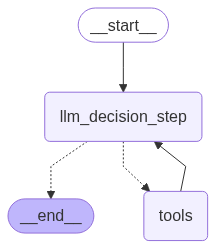

In [29]:
builder.compile()

In [30]:
react_graph=builder.compile()

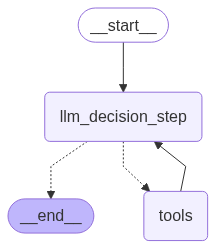

In [31]:
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [32]:
message={"messages":["what is the 2 times of Narendra Modi's age"]}
react_graph.invoke(message)

{'messages': [HumanMessage(content="what is the 2 times of Narendra Modi's age", additional_kwargs={}, response_metadata={}, id='a589ab0b-fe7f-432a-99fa-2e23bc038ce4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'f06fbjp8x', 'function': {'arguments': '{"a":73,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 275, 'prompt_tokens': 421, 'total_tokens': 696, 'completion_time': 1.055417845, 'prompt_time': 0.027061981, 'queue_time': 0.057750549, 'total_time': 1.082479826}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2d3fb028-a327-4a3e-9a7b-f8f82da8150c-0', tool_calls=[{'name': 'multiply', 'args': {'a': 73, 'b': 2}, 'id': 'f06fbjp8x', 'type': 'tool_call'}], usage_metadata={'input_tokens': 421, 'output_tokens': 275, 'total_tokens': 696}),
  ToolMessage(content='146', name='multiply', id='a86f03ed-96fe-4d24-a137-74

In [33]:
message={"messages":["what is the spped of light in m/s and multiply it by 10"]}
react_graph.invoke(message)

{'messages': [HumanMessage(content='what is the spped of light in m/s and multiply it by 10', additional_kwargs={}, response_metadata={}, id='6a3086d2-cda7-49fb-8efd-52d7c4d7214d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'm773fjgnd', 'function': {'arguments': '{"a":299792458,"b":10}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 254, 'prompt_tokens': 426, 'total_tokens': 680, 'completion_time': 0.962713106, 'prompt_time': 0.027211564, 'queue_time': 0.067167896, 'total_time': 0.98992467}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bae2dd1d-f0ef-4023-859a-d236c4db53b8-0', tool_calls=[{'name': 'multiply', 'args': {'a': 299792458, 'b': 10}, 'id': 'm773fjgnd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 426, 'output_tokens': 254, 'total_tokens': 680}),
  ToolMessage(content='2997924580', name='multip

In [34]:
message = [HumanMessage(content="What is the net worth of Elon Musk?")]
react_graph.invoke({"messages":message})

{'messages': [HumanMessage(content='What is the net worth of Elon Musk?', additional_kwargs={}, response_metadata={}, id='3057ccad-fbfd-4374-b1e0-e7656df5fb54'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v4yw8nt1v', 'function': {'arguments': '{"query":"Elon Musk net worth 2023"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 203, 'prompt_tokens': 419, 'total_tokens': 622, 'completion_time': 0.807547693, 'prompt_time': 0.033358635, 'queue_time': 0.054172735, 'total_time': 0.840906328}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--eb3707c1-4ce9-46a8-895b-a27623b11c65-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Elon Musk net worth 2023'}, 'id': 'v4yw8nt1v', 'type': 'tool_call'}], usage_metadata={'input_tokens': 419, 'output_tokens': 203, 'total_tokens': 622}),
  ToolMessage(content="

In [35]:
message = [HumanMessage(content="What is the net worth of Elon Musk?")]
response= react_graph.invoke({"messages":message})

In [36]:
response["messages"][-1].content

"Elon Musk's net worth has seen significant fluctuations recently. As of the latest information, his net worth dropped by $34 billion in June 2023, making it the second-largest fall in wealth recorded. However, he regained the top spot as the world's richest person later that month and maintained it until January 31, 2024, when he fell to the second position. Musk's net worth is primarily derived from his stakes in companies like Tesla, SpaceX, and other ventures."

In [37]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the net worth of Elon Musk?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (hr9aa40x7)
 Call ID: hr9aa40x7
  Args:
    query: Elon Musk net worth 2023
================================= Tool Message =================================
Name: duckduckgo_search

Elon Musk's net worth has taken a hit amid the billionaire's heated exchanges on social media with President Donald Trump. On June 6, the Bloomberg Billionaires Index recorded a $34 billion fall in Musk's net worth, the second-largest fall in wealth. Musk became the world's richest person again on June 8, 2023 and held onto the number one spot for the remainder of 2023. He fell to No. 2 on January 31, 2024. What Happened: Tesla CEO Elon Musk is the world's richest person and gets the majority of his net worth from ownership stakes in the electric vehicle company, SpaceX, xAI and o